<a href="https://colab.research.google.com/github/piyushparadkar1/ML_projects/blob/SEU/SEU1_RI_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of SEU1 product RI  using Machine learning model
Solvent extraction unit model in Lube oil refining.


#Install required packages

In [ ]:
!pip install gradio


In [64]:
# !pip -qq install dtreeviz                      

In [198]:
import pandas as pd 
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import absolute
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.core.arrays.period import timedelta
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import gradio
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor          # to import DT classifier and Regressor
from sklearn import tree
from sklearn.metrics import r2_score

import graphviz                                                                 # to import graphviz 
# from dtreeviz.trees import dtreeviz
%matplotlib inline

In [66]:
# from google.colab import drive
# drive.mount('/content/drive')

#Import Data from google drive, Read in dataframe 


Unit parameters saved as phd dataframe 



In [204]:
phd = pd.read_excel("/content/drive/MyDrive/seu1/phd_2018.xlsx")

In [205]:
phd.head()

,Timestamp,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average
0,2018-01-01 00:00:00,34.98,53.37,0.58,31.40,64.06
1,2018-01-01 01:00:00,35.23,53.58,0.64,31.43,64.10
2,2018-01-01 02:00:00,35.19,53.48,0.79,31.26,67.61
3,2018-01-01 03:00:00,35.00,53.74,0.66,30.96,72.71
4,2018-01-01 04:00:00,35.02,57.63,0.71,30.18,74.41


In [209]:
phd.iloc[30000:,:]

,Timestamp,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average
30000,2021-06-04 00:00:00,41.95,84.57,0.89,31.82,99.27
30001,2021-06-04 01:00:00,42.01,84.57,0.89,31.31,99.25
30002,2021-06-04 02:00:00,42.03,84.70,0.89,31.71,99.24
30003,2021-06-04 03:00:00,41.94,84.83,0.89,32.14,99.26
30004,2021-06-04 04:00:00,41.94,84.34,0.89,30.66,99.23
...,...,...,...,...,...,...
42500,2022-11-06 20:00:00,45.06,70.03,1.07,37.88,98.18
42501,2022-11-06 21:00:00,45.09,70.09,1.05,38.03,98.17
42502,2022-11-06 22:00:00,45.11,70.20,1.06,38.07,98.20
42503,2022-11-06 23:00:00,45.15,70.21,1.13,38.10,98.20


In [210]:
phd = phd.iloc[21000:,:]

In [211]:
phd.shape

(21505, 6)

In [212]:
phd.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average
count,21505.000000,21505.00000,21505.000000,21505.000000,21505.000000
mean,36.007837,63.21408,1.105652,32.310063,77.285514
std,12.119732,22.81581,0.467019,10.161533,22.393098
min,0.000000,-0.25000,0.000000,0.000000,0.000000
25%,36.280000,62.41000,0.900000,30.420000,74.390000
50%,39.830000,70.07000,1.150000,34.950000,75.610000
75%,41.990000,76.13000,1.400000,38.650000,98.800000
max,46.680000,85.00000,2.000000,43.000000,115.510000


In [213]:
phd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21505 entries, 21000 to 42504
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Timestamp              21505 non-null  datetime64[ns]
 1   02FC201.PV - Average   21505 non-null  float64       
 2   02FC203.pv - Average   21505 non-null  float64       
 3   02FC205.PV - Average   21505 non-null  float64       
 4   02FC202.PV - Average   21505 non-null  float64       
 5   02TI201A.PV - Average  21505 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1008.2 KB


lims dataframe has RI results from Lims for each day, normally thrice a day.

In [214]:
RI = pd.read_excel("/content/drive/MyDrive/seu1/SEU1_RI_2018.xlsx")

In [215]:
RI.head()

,,Id Numeric,Id Text,Sampled Date,Result Value
0,525594,525594,R-1-JAN-18 07:00-NMP-1-R000157,2018-01-01 06:00:00,1.4664
1,525733,525733,R-1-JAN-18 13:00-NMP-1-R000289,2018-01-01 13:17:00,1.4676
2,525812,525812,R-1-JAN-18 17:00-NMP-1-R000338,2018-01-01 18:00:00,1.4690
3,525990,525990,R-2-JAN-18 07:00-NMP-1-R000488,2018-01-02 06:00:00,1.4691
4,526162,526162,R-2-JAN-18 13:00-NMP-1-R000638,2018-01-02 13:00:00,1.4697


In [216]:
RI.tail()

,,Id Numeric,Id Text,Sampled Date,Result Value
5074,1210179,1210179,R-4-NOV-22 17:00-NMP-1-R107996,2022-11-04 17:00:00,1.4777
5075,1210308,1210308,N-5-NOV-22 01:52-NMP-1-R015848,2022-11-05 01:00:00,1.4780
5076,1210421,1210421,R-5-NOV-22 07:00-NMP-1-R108199,2022-11-05 07:00:00,1.4781
5077,1210479,1210479,R-5-NOV-22 13:00-NMP-1-R108236,2022-11-05 13:00:00,1.4780
5078,1210548,1210548,R-5-NOV-22 17:00-NMP-1-R108289,2022-11-05 17:00:00,1.4777


In [217]:
RI.shape

(5079, 5)

In [218]:
RI.columns

Index([' ', 'Id Numeric', 'Id Text', 'Sampled Date', 'Result Value'], dtype='object')

In [219]:
RI = RI[['Id Text','Result Value']]

In [220]:
RI.head()

,Id Text,Result Value
0,R-1-JAN-18 07:00-NMP-1-R000157,1.4664
1,R-1-JAN-18 13:00-NMP-1-R000289,1.4676
2,R-1-JAN-18 17:00-NMP-1-R000338,1.4690
3,R-2-JAN-18 07:00-NMP-1-R000488,1.4691
4,R-2-JAN-18 13:00-NMP-1-R000638,1.4697


In [221]:
RI.describe()

,Result Value
count,5079.000000
mean,1.470536
std,0.142995
min,0.000000
25%,1.464800
50%,1.468200
75%,1.475800
max,11.474900


In [222]:
RI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5079 entries, 0 to 5078
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id Text       5079 non-null   object 
 1   Result Value  5079 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.5+ KB


In [223]:
p202 = pd.read_excel("/content/drive/MyDrive/seu1/P202_2018.xlsx")

In [224]:
p202.head()

,,Id Numeric,Id Text,Sampled Date,Result Value
0,525686,525686,R-1-JAN-18 09:00-NMP-1-R000248,2018-01-01 10:23:00,4.5
1,525730,525730,R-1-JAN-18 13:00-NMP-1-R000286,2018-01-01 13:17:00,4.4
2,525809,525809,R-1-JAN-18 17:00-NMP-1-R000335,2018-01-01 18:00:00,5.4
3,525846,525846,R-1-JAN-18 22:00-NMP-1-R000359,2018-01-01 20:45:00,5.2
4,526114,526114,R-2-JAN-18 09:00-NMP-1-R000599,2018-01-02 10:18:00,5.4


In [225]:
p202.tail()

,,Id Numeric,Id Text,Sampled Date,Result Value
5101,1230689,1230689,R-25-DEC-22 13:00-NMP-1-R125312,2022-12-25 13:00:00,3.9
5102,1230779,1230779,R-25-DEC-22 22:00-NMP-1-R125386,2022-12-25 22:00:00,3.5
5103,1231014,1231014,R-26-DEC-22 07:00-NMP-1-R125596,2022-12-26 07:00:00,4.7
5104,1231122,1231122,R-26-DEC-22 13:00-NMP-1-R125684,2022-12-26 13:00:00,4.5
5105,1231233,1231233,R-26-DEC-22 22:00-NMP-1-R125758,2022-12-26 22:00:00,2.8


In [226]:
p202.columns

Index([' ', 'Id Numeric', 'Id Text', 'Sampled Date', 'Result Value'], dtype='object')

In [227]:
p202 = p202[['Id Text','Result Value']]

In [228]:
p202.describe()

,Result Value
count,5106.000000
mean,4.036951
std,1.486583
min,0.500000
25%,3.500000
50%,4.000000
75%,4.500000
max,45.000000


In [229]:
p202.head()

,Id Text,Result Value
0,R-1-JAN-18 09:00-NMP-1-R000248,4.5
1,R-1-JAN-18 13:00-NMP-1-R000286,4.4
2,R-1-JAN-18 17:00-NMP-1-R000335,5.4
3,R-1-JAN-18 22:00-NMP-1-R000359,5.2
4,R-2-JAN-18 09:00-NMP-1-R000599,5.4


In [230]:
p202.shape

(5106, 2)

#Mapping sample time with unit parameters with Timestamp


In [231]:
def get_timestamp(string):
    timestamp = string[2:-14]
    return (timestamp)

In [232]:
def transform_lab(df):
    df['Timestamp'] = pd.to_datetime(df['Id Text'].apply(get_timestamp))
    df['Timestamp'] = df['Timestamp'] - timedelta(hours = 4)
    df.drop(['Id Text'],axis = 1, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df = df[['Timestamp', 'Result Value']]
    return df


In [233]:
transform_lab(p202)

,Timestamp,Result Value
0,2018-01-01 05:00:00,4.5
1,2018-01-01 09:00:00,4.4
2,2018-01-01 13:00:00,5.4
3,2018-01-01 18:00:00,5.2
4,2018-01-02 05:00:00,5.4
...,...,...
5101,2022-12-25 09:00:00,3.9
5102,2022-12-25 18:00:00,3.5
5103,2022-12-26 03:00:00,4.7
5104,2022-12-26 09:00:00,4.5


In [234]:
transform_lab(RI)

,Timestamp,Result Value
0,2018-01-01 03:00:00,1.4664
1,2018-01-01 09:00:00,1.4676
2,2018-01-01 13:00:00,1.4690
3,2018-01-02 03:00:00,1.4691
4,2018-01-02 09:00:00,1.4697
...,...,...
5074,2022-11-04 13:00:00,1.4777
5075,2022-11-04 21:52:00,1.4780
5076,2022-11-05 03:00:00,1.4781
5077,2022-11-05 09:00:00,1.4780


In [235]:
# RI['Timestamp'] = pd.to_datetime(RI['Id Text'].apply(get_timestamp))


In [236]:
# RI['Timestamp'] = RI['Timestamp'] - timedelta(hours = 4)

In [237]:
# RI.drop(['Id Text'],axis = 1, inplace = True)

In [238]:
# RI.reset_index(drop = True, inplace = True)


In [239]:
RI.head()

,Result Value,Timestamp
0,1.4664,2018-01-01 03:00:00
1,1.4676,2018-01-01 09:00:00
2,1.4690,2018-01-01 13:00:00
3,1.4691,2018-01-02 03:00:00
4,1.4697,2018-01-02 09:00:00


In [240]:
# p202['Timestamp'] = pd.to_datetime(p202['Id Text'].apply(get_timestamp))

In [241]:
# p202.drop(['Id Text'],axis = 1, inplace = True)

In [242]:
# p202.reset_index(drop = True, inplace = True)


In [243]:
df_RI_p202 = pd.merge_asof(p202.sort_values('Timestamp'),RI.sort_values('Timestamp'), left_on=['Timestamp'], right_on=['Timestamp'])


In [244]:
df = phd.merge(df_RI_p202, how='inner', on='Timestamp')

In [245]:
df.head()

,Timestamp,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average,Result Value_x,Result Value_y
0,2020-05-25 03:00:00,34.93,63.97,1.21,35.05,65.38,4.6,1.4537
1,2020-05-25 09:00:00,34.97,63.97,1.20,35.71,65.43,3.8,1.4569
2,2020-05-25 18:00:00,40.00,70.01,1.92,34.92,74.78,3.6,1.4651
3,2020-05-26 03:00:00,40.63,79.97,1.50,39.63,75.21,4.3,1.4677
4,2020-05-26 09:00:00,40.91,79.88,1.49,39.73,75.14,3.8,1.4702


In [246]:
df.drop('Timestamp', axis = 1, inplace = True)

In [247]:
df = df.rename(columns={'Result Value_x': 'p202','Result Value_y': 'RI', })

In [248]:
df.dropna(inplace = True)

In [249]:
df.shape

(2316, 7)

In [250]:
df.head()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average,p202,RI
0,34.93,63.97,1.21,35.05,65.38,4.6,1.4537
1,34.97,63.97,1.20,35.71,65.43,3.8,1.4569
2,40.00,70.01,1.92,34.92,74.78,3.6,1.4651
3,40.63,79.97,1.50,39.63,75.21,4.3,1.4677
4,40.91,79.88,1.49,39.73,75.14,3.8,1.4702


In [251]:
# df = df.rename(columns={'Result Value_x': 'RI', 'Result Value_y': 'p202'})

In [252]:
# df.dropna(inplace = True)

In [253]:
# p202['Timestamp'] = pd.to_datetime(p202['Id Text'].apply(get_timestamp))

In [254]:
# p202.drop(['Id Text'],axis = 1, inplace = True)

In [255]:
# p202.reset_index(drop = True, inplace = True)


In [256]:
# p202.head()

In [257]:
#p202.shape,RI.shape

In [258]:
# lims.head()

In [259]:
# pd_open = pd.merge_asof(RI.sort_values('Timestamp'), p202.sort_values('Timestamp'), left_on=['Timestamp'], right_on=['Timestamp'])


In [260]:
# pd_open.head()

In [261]:
# pd_open.tail(10)

In [262]:
# lims.tail(10)

In [263]:
# p202.tail(11)

In [264]:
# pd_open.shape

#Creating Dataframe for 500N


In [265]:
df_500 = df[ (df['02TI201A.PV - Average'] > 90) & (df['02TI201A.PV - Average']<=105)]


In [266]:
df_500 = df_500.reset_index(drop = True)

In [267]:
df_500.head()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average,p202,RI
0,40.01,81.25,1.85,33.50,100.40,4.2,1.4757
1,43.91,79.01,1.49,33.31,100.46,4.0,1.4773
2,43.97,78.97,1.49,34.40,100.42,3.9,1.4766
3,43.98,78.98,1.60,33.92,100.37,4.2,1.4765
4,44.01,79.01,1.60,33.88,100.30,3.7,1.4775


In [268]:
df_500.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,02TI201A.PV - Average,p202,RI
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,41.813651,71.121770,1.208449,33.983822,99.153883,3.979144,1.476527
std,3.283565,7.576737,0.387337,4.823625,1.270420,2.439502,0.005103
min,32.660000,50.990000,0.350000,0.000000,90.800000,1.400000,1.461200
25%,39.530000,66.965000,0.945000,31.370000,98.890000,3.300000,1.474450
50%,42.990000,71.330000,1.140000,34.400000,99.250000,3.900000,1.476500
75%,44.810000,77.495000,1.500000,37.055000,99.920000,4.400000,1.478400
max,46.190000,84.830000,2.000000,43.000000,102.710000,45.000000,1.580800


In [269]:
df_500.drop(['02TI201A.PV - Average'], axis = 1, inplace = True)

In [270]:
df_500.shape

(819, 6)

In [271]:
df_500['RI'].quantile(.995)

1.484874

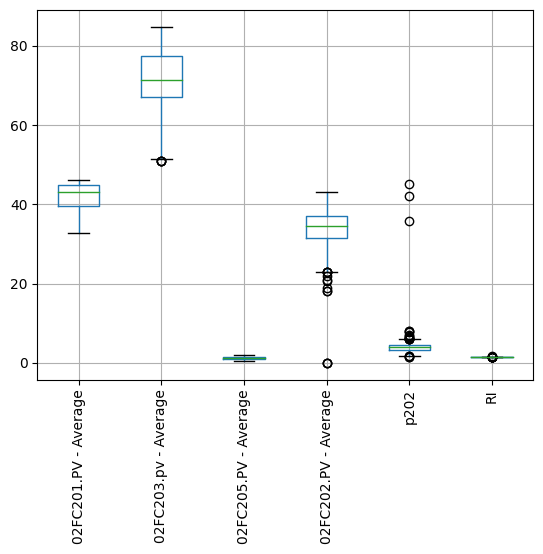

In [272]:
# Checking for outliers
df_500.boxplot()
plt.xticks(rotation=90)
plt.show()

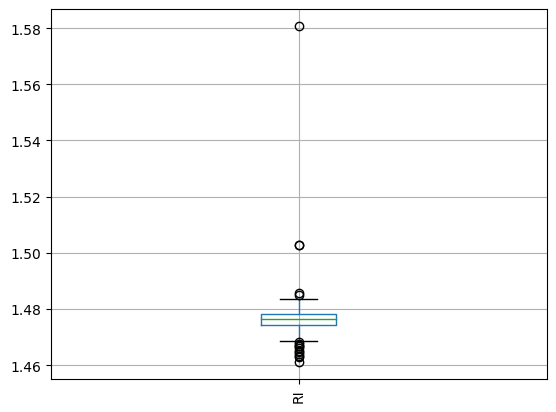

In [273]:
df_500[['RI']].boxplot()
plt.xticks(rotation=90)
plt.show()

In [274]:
# Handing outliers
outlier_colms = ['02FC201.PV - Average', '02FC203.pv - Average', '02FC205.PV - Average',
       '02FC202.PV - Average', 'p202']

# df1_500 = df_500.copy()
# df_500.reset_index(inplace = True)

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df[colm].quantile(.25)
    q3 = df[colm].quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df
    
for colm in outlier_colms:
    df_500 = handle_outliers(df_500, colm)



        # df.loc[i,colm]= upper_bound


In [275]:
def outlier_RI(df,colm):
    
    q1 = df[colm].quantile(.03)
    q3 = df[colm].quantile(.995)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

df_500 = handle_outliers(df_500, 'RI')

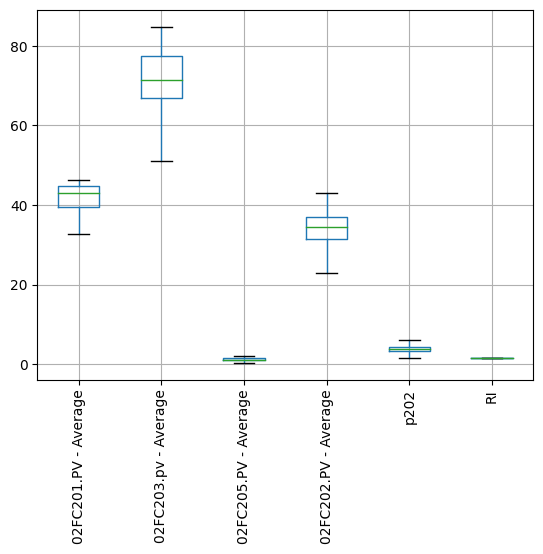

In [276]:
df_500.boxplot()
plt.xticks(rotation=90)
plt.show()

In [277]:
df_500.shape

(819, 6)

In [278]:
df_500.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,p202,RI
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,41.813651,71.122589,1.208449,34.090052,3.841598,1.476407
std,3.283565,7.574571,0.387337,4.346109,0.898322,0.003208
min,32.660000,51.170000,0.350000,22.842500,1.650000,1.468525
25%,39.530000,66.965000,0.945000,31.370000,3.300000,1.474450
50%,42.990000,71.330000,1.140000,34.400000,3.900000,1.476500
75%,44.810000,77.495000,1.500000,37.055000,4.400000,1.478400
max,46.190000,84.830000,2.000000,43.000000,6.050000,1.484325


In [279]:
df_500.head()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,p202,RI
0,40.01,81.25,1.85,33.50,4.2,1.4757
1,43.91,79.01,1.49,33.31,4.0,1.4773
2,43.97,78.97,1.49,34.40,3.9,1.4766
3,43.98,78.98,1.60,33.92,4.2,1.4765
4,44.01,79.01,1.60,33.88,3.7,1.4775


#Creating dataframe for 150N and TOBS

For 150N

In [280]:
df_150 = df[ (df['02TI201A.PV - Average'] > 72) & (df['02TI201A.PV - Average']<=85)]

In [281]:
df_150 = df_150.reset_index(drop = True)

In [282]:
df_150.shape

(1268, 7)

In [283]:
df_150.drop(['02TI201A.PV - Average'], axis = 1, inplace = True)

In [284]:
df_150.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,p202,RI
count,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000
mean,39.643360,70.869779,1.263202,35.527216,4.135103,1.465279
std,2.223053,7.393690,0.307004,7.731940,1.265221,0.004580
min,32.810000,49.330000,0.290000,0.000000,0.500000,1.450000
25%,38.030000,65.415000,1.050000,32.830000,3.600000,1.463700
50%,40.010000,72.030000,1.250000,36.685000,4.100000,1.465500
75%,41.282500,76.852500,1.450000,40.542500,4.600000,1.467200
max,44.840000,83.930000,2.000000,43.000000,37.800000,1.571300


In [285]:
df_150.shape

(1268, 6)

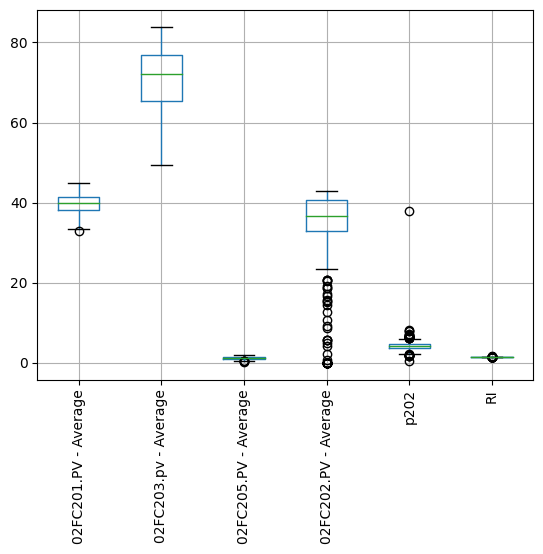

In [286]:
# Checking for outliers
df_150.boxplot()
plt.xticks(rotation=90)
plt.show()

In [287]:
# Handing outliers
outlier_colms = ['02FC201.PV - Average', '02FC203.pv - Average', '02FC205.PV - Average',
       '02FC202.PV - Average', 'p202', 'RI']



def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df[colm].quantile(.25)
    q3 = df[colm].quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df
    
for colm in outlier_colms:
    df_150 = handle_outliers(df_150, colm)

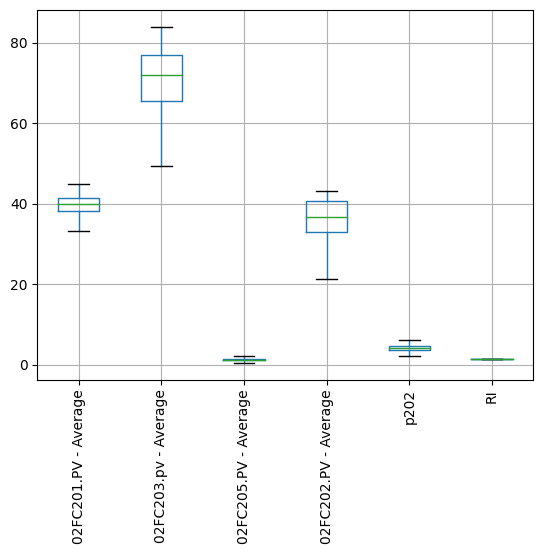

In [288]:
df_150.boxplot()
plt.xticks(rotation=90)
plt.show()

In [289]:
df_150.shape

(1268, 6)

In [290]:
df_150.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,p202,RI
count,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000
mean,39.643629,70.869779,1.263509,36.142629,4.102453,1.465315
std,2.222245,7.393690,0.306131,5.478709,0.799451,0.002836
min,33.151250,49.330000,0.450000,21.261250,2.100000,1.458450
25%,38.030000,65.415000,1.050000,32.830000,3.600000,1.463700
50%,40.010000,72.030000,1.250000,36.685000,4.100000,1.465500
75%,41.282500,76.852500,1.450000,40.542500,4.600000,1.467200
max,44.840000,83.930000,2.000000,43.000000,6.100000,1.472450


For TOBS

In [291]:
df_TOBS = df[ (df['02TI201A.PV - Average'] > 60) & (df['02TI201A.PV - Average']<=70)]

In [292]:
df_TOBS = df_TOBS.reset_index(drop = True)

In [293]:
df_TOBS.shape

(186, 7)

In [294]:
df_TOBS.drop(['02TI201A.PV - Average'], axis = 1, inplace = True)

In [295]:
df_TOBS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   02FC201.PV - Average  186 non-null    float64
 1   02FC203.pv - Average  186 non-null    float64
 2   02FC205.PV - Average  186 non-null    float64
 3   02FC202.PV - Average  186 non-null    float64
 4   p202                  186 non-null    float64
 5   RI                    186 non-null    float64
dtypes: float64(6)
memory usage: 8.8 KB


In [296]:
df_TOBS.describe()

,02FC201.PV - Average,02FC203.pv - Average,02FC205.PV - Average,02FC202.PV - Average,p202,RI
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,35.460323,67.883333,0.978441,35.294785,4.122086,1.449872
std,1.291931,10.022157,0.276803,5.218177,3.153059,0.073535
min,32.020000,50.110000,0.170000,12.180000,1.000000,0.453400
25%,34.882500,58.957500,0.767500,32.290000,3.200000,1.452800
50%,35.030000,67.005000,1.000000,34.780000,3.900000,1.454450
75%,36.217500,77.087500,1.200000,39.025000,4.600000,1.457475
max,39.930000,85.000000,1.700000,43.000000,44.400000,1.466400


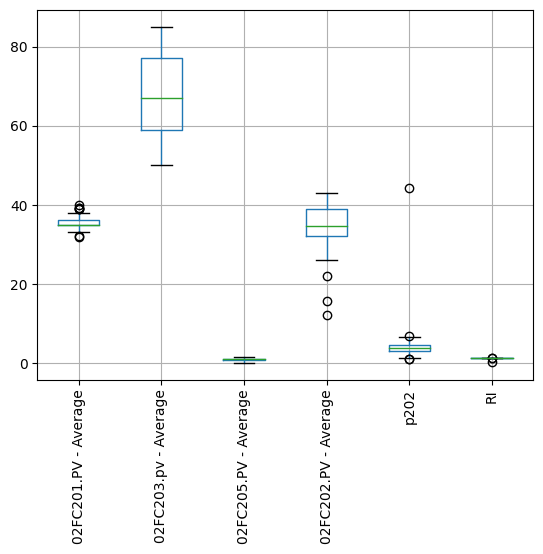

In [297]:
df_TOBS.boxplot()
plt.xticks(rotation=90)
plt.show()

In [298]:
# Handing outliers
outlier_colms = ['02FC201.PV - Average', '02FC203.pv - Average', '02FC205.PV - Average',
       '02FC202.PV - Average', 'p202', 'RI']



def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df[colm].quantile(.25)
    q3 = df[colm].quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df
    
for colm in outlier_colms:
    df_TOBS = handle_outliers(df_TOBS, colm)

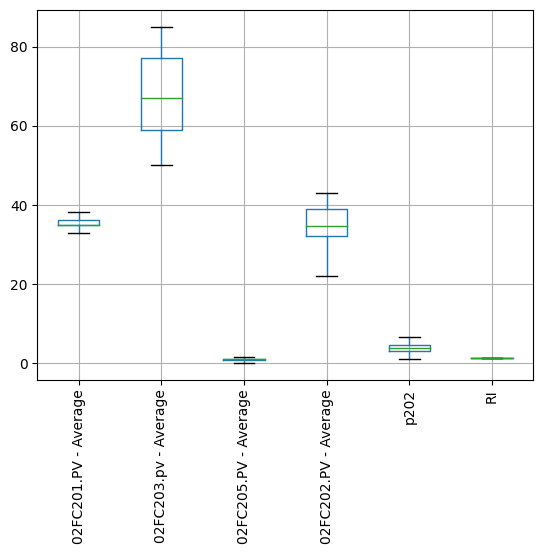

In [299]:
df_TOBS.boxplot()
plt.xticks(rotation=90)
plt.show()

In [300]:
df_TOBS.shape

(186, 6)

#Finding correlation among *features*


***For 500N***

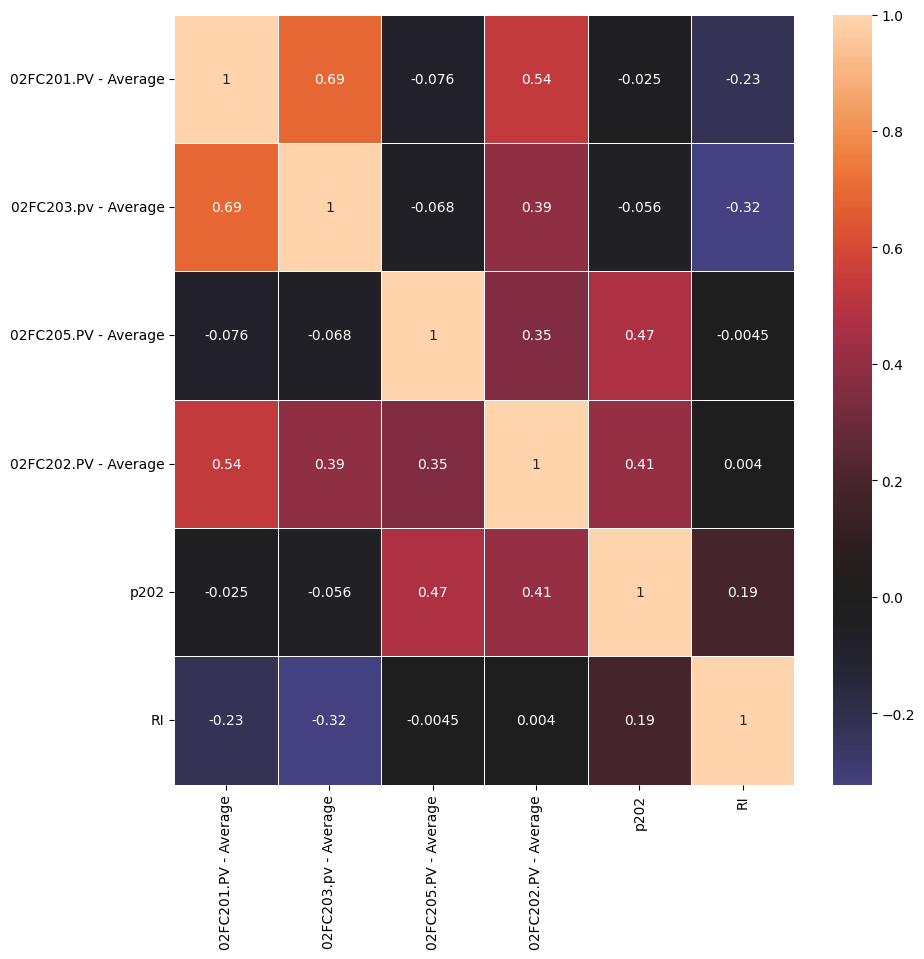

In [301]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_500.corr(), annot=True, linewidth=0.5, center=0)
plt.show()

For 150N

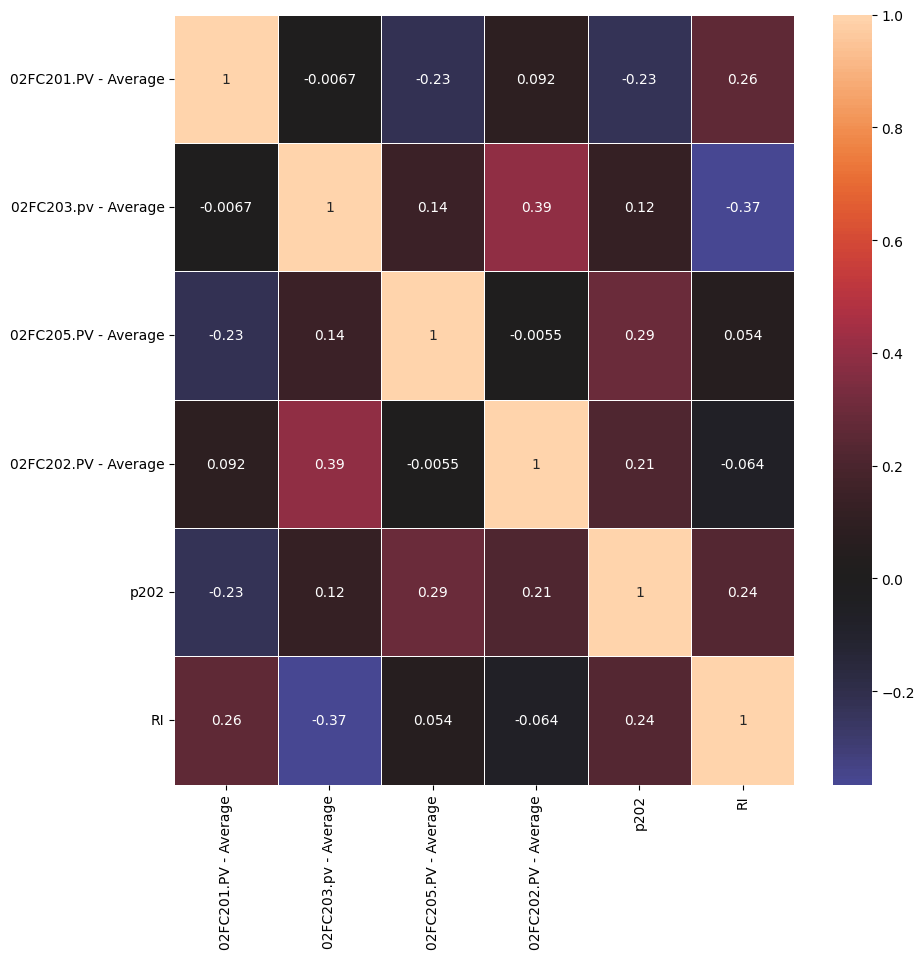

In [302]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_150.corr(), annot=True, linewidth=0.5, center=0)
plt.show()

For TOBS

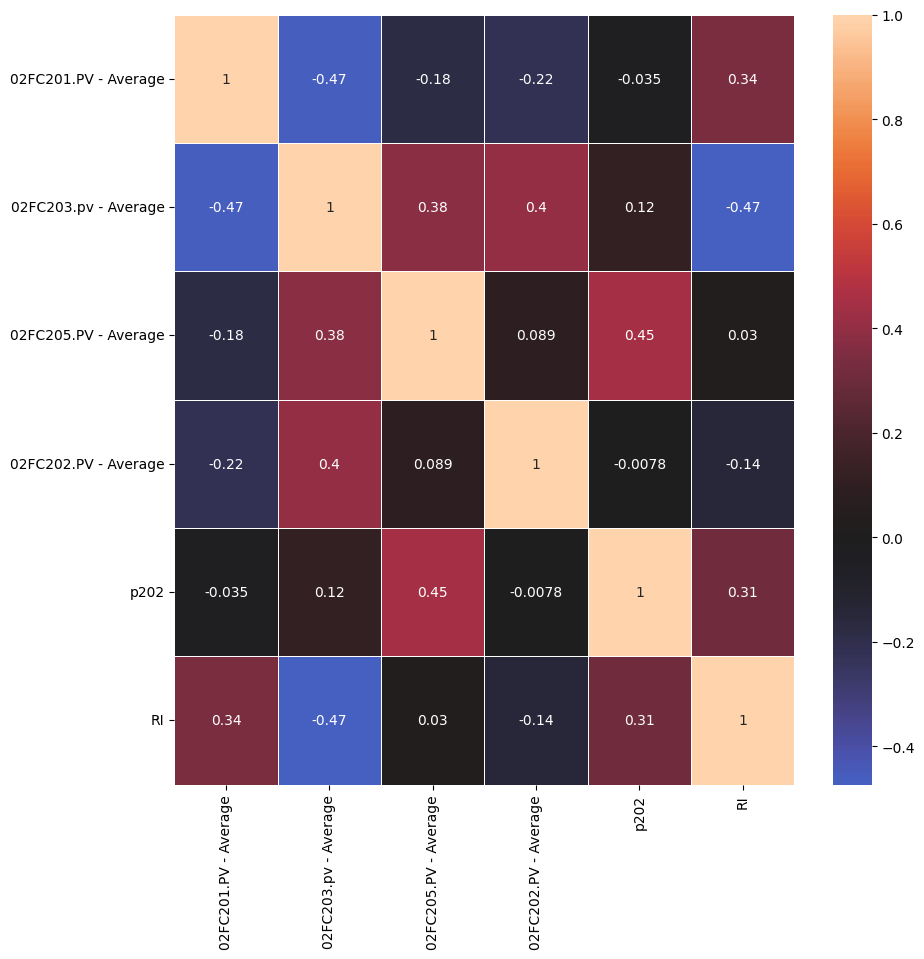

In [303]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_TOBS.corr(), annot=True, linewidth=0.5, center=0)
plt.show()

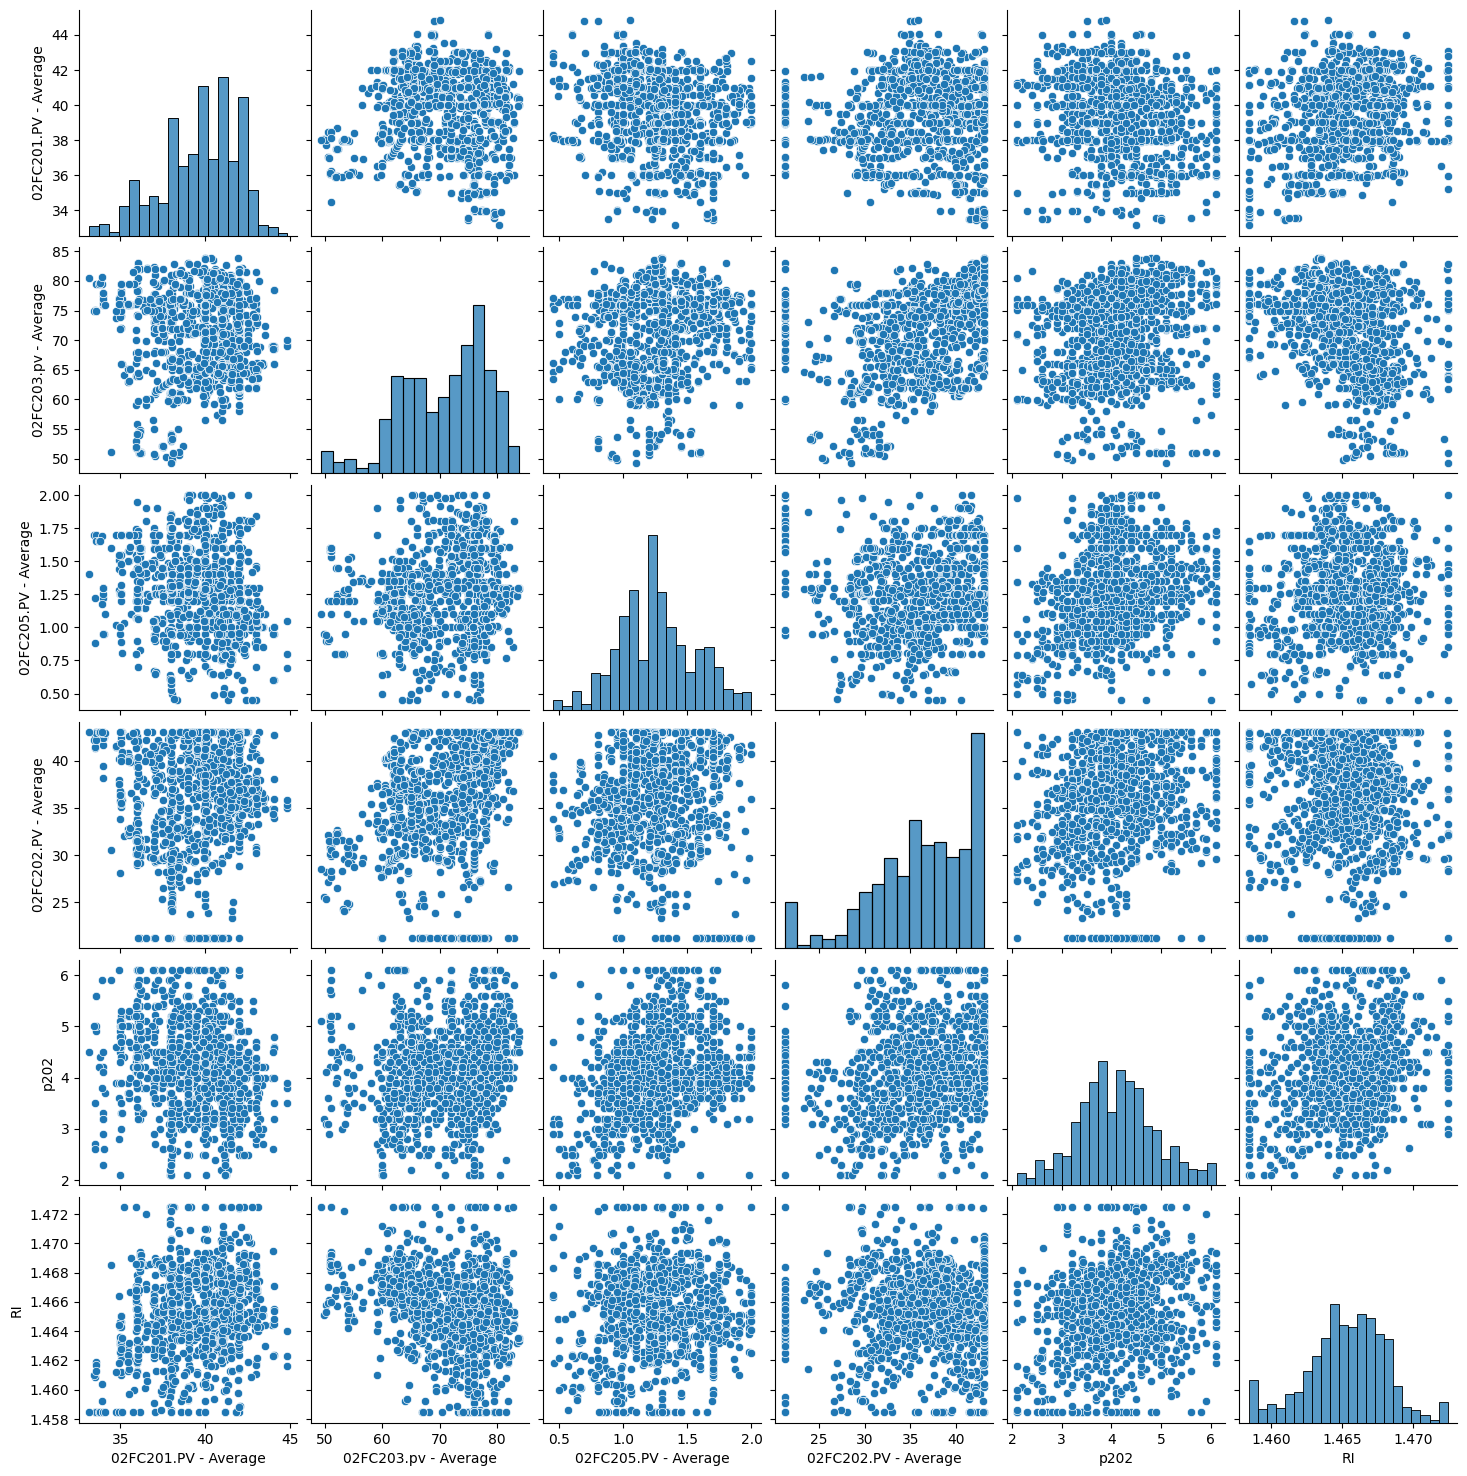

In [304]:
sns.pairplot(data=df_150)

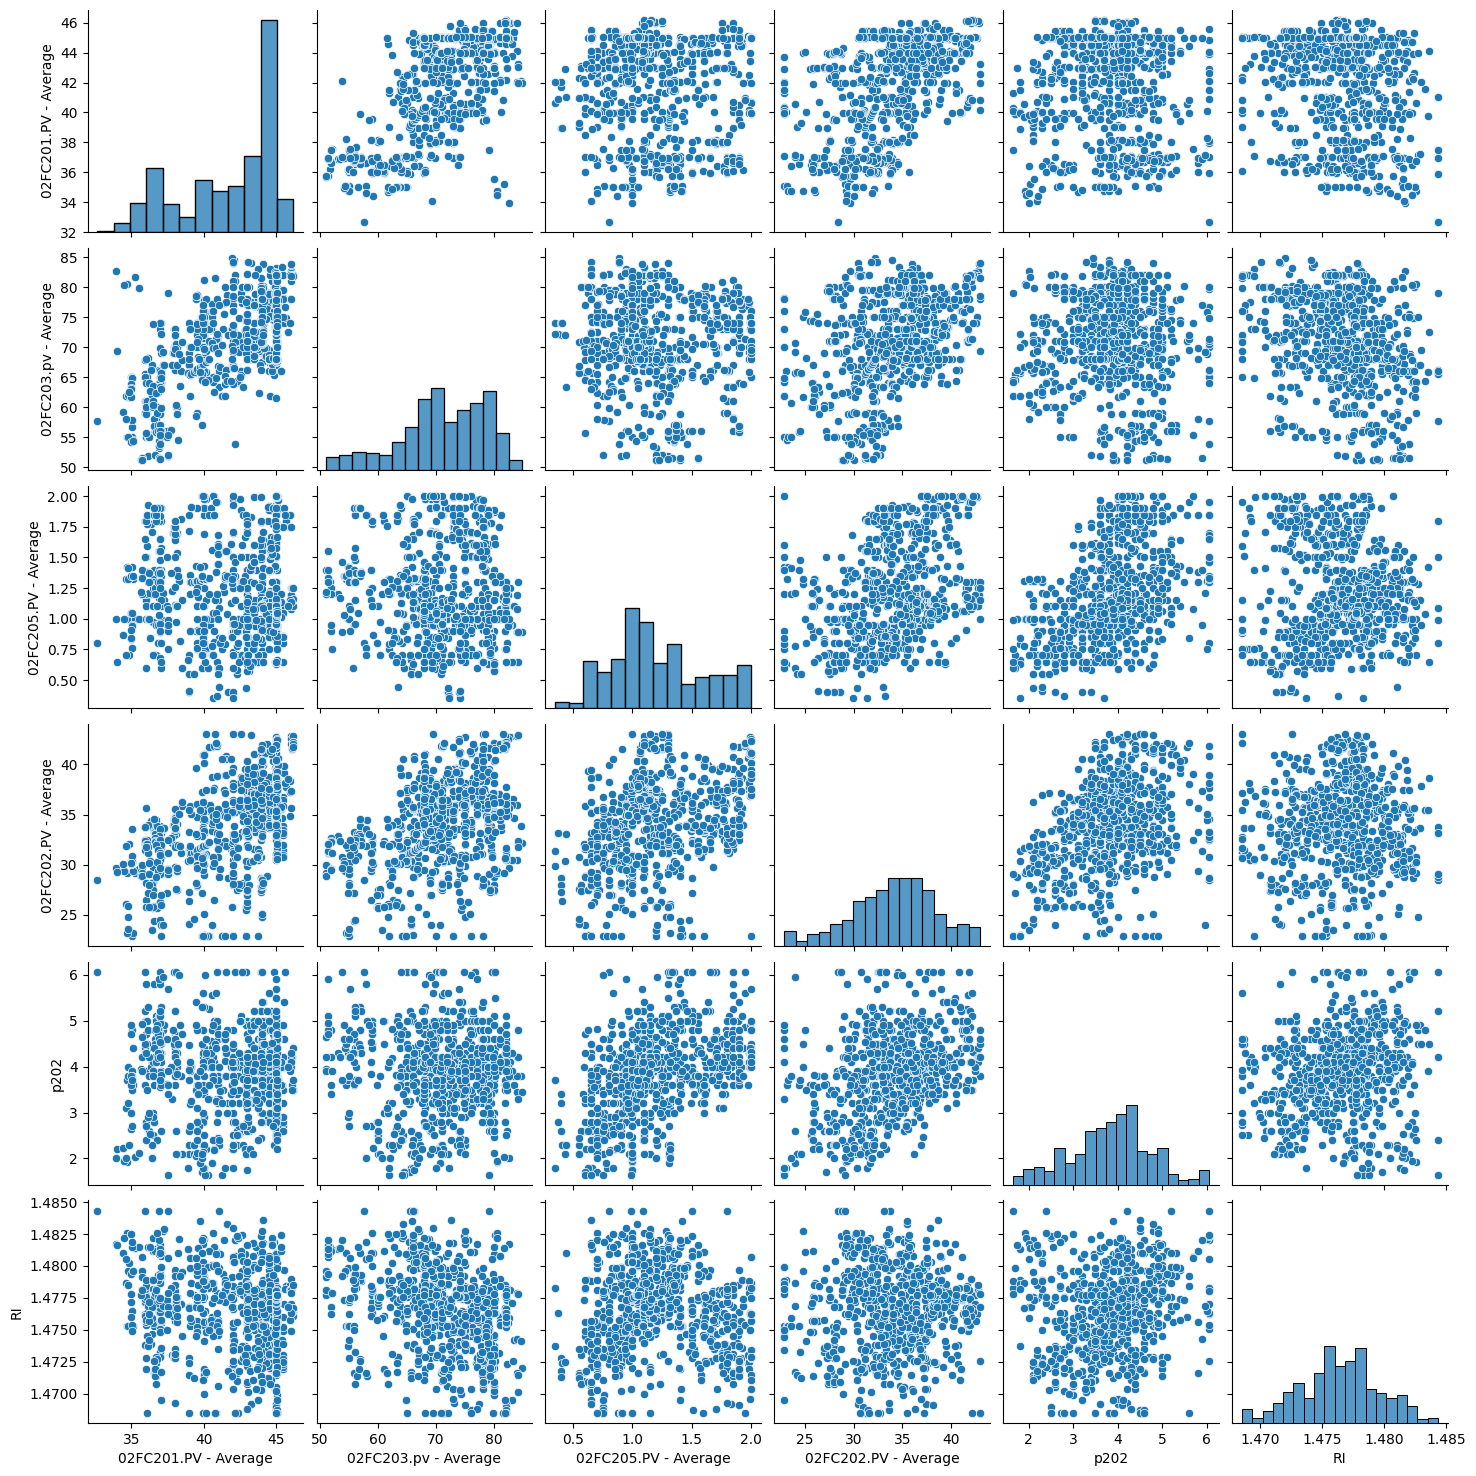

In [305]:
sns.pairplot(data=df_500)

# Modelling using XGBoost regression

#*For 150N*

In [306]:
X = df_150.drop(['RI'], axis = 1)
y = df_150['RI']

In [307]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((887, 5), (887,), (381, 5), (381,))

Using Linear regression

In [308]:
model_lr_150N = LinearRegression(fit_intercept=True)                   # instantiate LinearRegression
model_lr_150N.fit(x_train,y_train)

LinearRegression()

In [309]:
pred = model_lr_150N.predict(x_test)

In [310]:
print('Mean Absolute Error (MAE) :', mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
print('Mean Root Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
print('R_2', r2_score(y_test, pred))


Mean Absolute Error (MAE) : 0.001722949856067513
Mean Squared Error (MSE): 5.033703524111627e-06
Mean Root Squared Error (RMSE): 0.002243591657167504
R_2 0.33704300467175685


Using XGBoost (to handle outliers)

In [311]:
model_150 = XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=1)

In [312]:
model_150.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [313]:
pred = model_150.predict(x_test)

In [314]:
print('Mean Absolute Error (MAE) :', mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
print('Mean Root Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
print('R_2', r2_score(y_test, pred))


Mean Absolute Error (MAE) : 0.0014892671399854953
Mean Squared Error (MSE): 4.306652314259272e-06
Mean Root Squared Error (RMSE): 0.002075247530840423
R_2 0.43279828370729523


<BarContainer object of 5 artists>

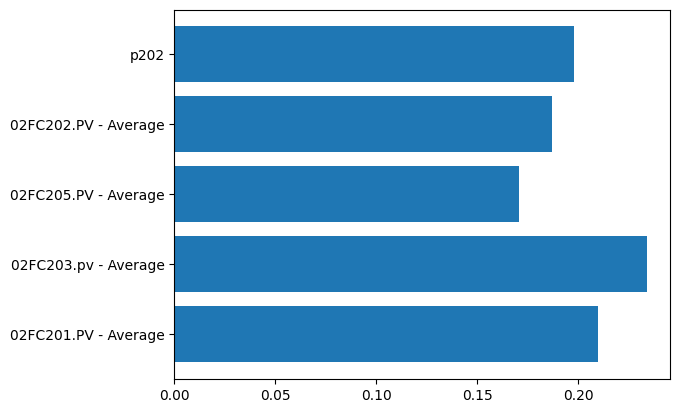

In [315]:
plt.barh(X.columns.values, model_150.feature_importances_)


In [316]:
# params = {
#     'n_estimators':[500,1000],
#     # 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
#     # 'subsample':[i/10.0 for i in range(6,11)],
#     # 'max_depth' : [ 3, 4, 5, 6,7, 8,9],
#     'eval_metric': ['rmse'],
#     # 'eta': [i/10.0 for i in range(3,6)],
#     # 'min_child_weight' : [ 1, 3, 5, 7 ],
#     'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#     'colsample_bytree' : [0.7, 0.8, 0.9,1 ]
# }

In [317]:
# # from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# import time
# reg = XGBRegressor(nthread=-1)

In [318]:

# n_iter_search = 100
# random_search = RandomizedSearchCV(reg, param_distributions=params,
#                                    n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(x_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))


In [319]:
# random_search.best_estimator_

#*For 500N*


In [320]:
X = df_500.drop(['RI'], axis = 1)
y = df_500['RI']

In [321]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((491, 5), (491,), (328, 5), (328,))

In [322]:
model_lr_500 = LinearRegression(fit_intercept=True)                   # instantiate LinearRegression
model_lr_500.fit(x_train,y_train)

LinearRegression()

In [323]:
pred = model_lr_500.predict(x_test)

In [324]:
print('Mean Absolute Error (MAE) :', mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
print('Mean Root Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
print('R_2', r2_score(y_test, pred))


Mean Absolute Error (MAE) : 0.0023545921492570216
Mean Squared Error (MSE): 9.023850333951355e-06
Mean Root Squared Error (RMSE): 0.0030039724256309937
R_2 0.1654336020208852


In [325]:
model_500 = XGBRegressor(n_estimators=500, max_depth=7, eta=0.05, subsample=0.7, colsample_bytree=1)

In [326]:
model_500.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [327]:
pred = model_500.predict(x_test)

In [328]:
print('Mean Absolute Error (MAE) :', mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
print('Mean Root Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
print('R_2', r2_score(y_test, pred))


Mean Absolute Error (MAE) : 0.0018671960394556866
Mean Squared Error (MSE): 6.732893496471095e-06
Mean Root Squared Error (RMSE): 0.002594781974746837
R_2 0.37731162803246243


<BarContainer object of 5 artists>

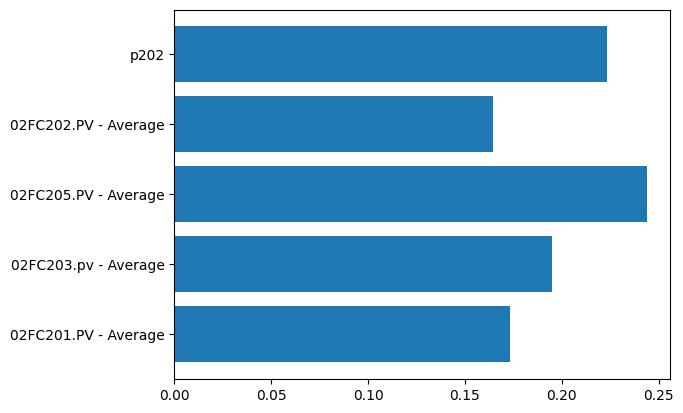

In [329]:
plt.barh(X.columns.values, model_500.feature_importances_)

Hyperparameter tuning for 500N

In [330]:
# parameters = {'objective':['reg:squarederror'],
#               'booster':['gbtree','gblinear'],
#               'learning_rate': [0.1], 
#               'max_depth': [7,10,15,20],
#               'min_child_weight': [10,15,20,25],
#               'colsample_bytree': [0.8, 0.9, 1],
#               'n_estimators': [300,400,500,600],
#               "reg_alpha"   : [0.5,0.2,1],
#               "reg_lambda"  : [2,3,5],
#               "gamma"       : [1,2,3]}

In [331]:
# xgb_model = XGBRegressor(random_state=30)


In [332]:
# dt = DecisionTreeRegressor(max_depth=3, random_state=1234)
# model = dt.fit(x_test, y_test)

In [333]:
# text_representation = tree.export_text(dt)
# print(text_representation)

In [334]:
# Visualize tree using plot_tree
# fig = plt.figure(figsize=(15,10))
# _ = tree.plot_tree(dt, feature_names=x_test.columns, filled=True)

In [335]:
# # Visualize tree using graphviz
# dot_data = tree.export_graphviz(dt, out_file=None, 
#                                 feature_names=x_test.columns,  
#                                 filled=True)
# graphviz.Source(dot_data, format="png") 

In [336]:
# # Visualize tree using dtreeviz
# vizualize = dtreeviz(dt, X, y,
#                 target_name="target",
#                 feature_names=x_test.columns)
# vizualize

#Interactive API (using Gradio)


In [337]:
def predict_RI(feed_type,Feed_flow,NMP_flow,Raffinate_solution,NMP_water_flow,p202):
    feature = pd.DataFrame.from_dict({'02FC201.PV - Average':[Feed_flow], '02FC203.pv - Average':[NMP_flow], '02FC205.PV - Average':[NMP_water_flow], '02FC202.PV - Average':[Raffinate_solution],'p202':[p202]})
    if feed_type == '500N':
        RI = model_500.predict(feature)
    else: 
        RI = model_150.predict(feature)

    return RI

In [338]:
feed_selector = gradio.inputs.Dropdown(['500N', '150N'], type="value", default=None, label='Choose feed type')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:219: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:222: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(


In [339]:
in_F201 = gradio.inputs.Number()
in_F202 = gradio.inputs.Number()
in_F203 = gradio.inputs.Number()
in_F205 = gradio.inputs.Number()
in_p202 = gradio.inputs.Number()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:62: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(value=default, label=label, optional=optional)


In [340]:
out_RI = gradio.inputs.Number()

In [341]:
iface = gradio.Interface(
  fn = predict_RI, 
  inputs = [feed_selector,in_F201,in_F202,in_F203,in_F205,in_p202],
  outputs = [out_RI],
  title = 'SEU1 Raffinate RI Prediction',
  description = 'Hi, presenting you a Machine learning based prediction tool for SEU1 Raffinate RI.    Example entry ::  Feed type = 500NFeed flow (FC201)=45m3/h, NMP flow (FC203) = 65m3/h, Raffinate sol flow (FC202) = 38m3/h, NMP water flow (FC205) = 1.5m3/h ',
  article = 'This is an intorductory first tesing version. I request you to test as many data as possible and if you get any error, please share to make this more robust, provide suggestions to include/exclude parameters. *Data from 1st Jan 2018 to 8th Nov 2022 is used to train the model.                Created by : Piyush Paradkar, Asst. Manager , LR Operations')
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c7781c9039ccb33ee8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
